In [43]:
import os
import pandas as pd

df = pd.read_csv("/home/werowe/Documents/weather/combined_weather.csv", usecols=["datetime","temp", "humidity", "precip", "sealevelpressure", "cloudcover"])

datetime=df['datetime']

df.drop(columns=["datetime"], inplace=True)

In [44]:
df 

,temp,humidity,precip,sealevelpressure,cloudcover
0,27.8,88.66,0.0,1001.3,85.6
1,27.9,88.17,0.0,1000.9,49.4
2,27.9,88.16,0.0,1000.9,98.8
3,27.2,88.58,0.0,1000.9,97.2
4,27.0,83.56,0.0,1000.0,93.0
...,...,...,...,...,...
32906,26.0,73.86,0.0,1012.9,27.4
32907,25.1,77.85,0.0,1012.9,27.4
32908,24.9,70.20,0.0,1013.4,0.0
32909,25.0,66.16,0.0,1013.0,0.0


In [45]:
raw_data=df.values
raw_data

array([[  27.8 ,   88.66,    0.  , 1001.3 ,   85.6 ],
       [  27.9 ,   88.17,    0.  , 1000.9 ,   49.4 ],
       [  27.9 ,   88.16,    0.  , 1000.9 ,   98.8 ],
       ...,
       [  24.9 ,   70.2 ,    0.  , 1013.4 ,    0.  ],
       [  25.  ,   66.16,    0.  , 1013.  ,    0.  ],
       [  24.  ,   69.74,    0.  , 1013.  ,    0.  ]])

In [46]:
import numpy as np

print(np.isnan(raw_data).sum())  # Count total NaNs
print(np.isnan(raw_data).sum(axis=0))  # NaNs per column


0
[0 0 0 0 0]


In [47]:
import numpy as np

temperature = df['temp'].values
temperature
 

array([27.8, 27.9, 27.9, ..., 24.9, 25. , 24. ])

In [49]:
 num_train_samples = int(0.5 * len(raw_data))
 num_val_samples = int(0.25 * len(raw_data))
 num_test_samples = len(raw_data) - num_train_samples - num_val_samples
 print("num_train_samples:", num_train_samples)
 print("num_val_samples:", num_val_samples)
 print("num_test_samples:", num_test_samples)
 

num_train_samples: 16455
num_val_samples: 8227
num_test_samples: 8229


In [50]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [51]:
raw_data

array([[ 1.69499526,  1.4095203 , -0.10011548, -2.75465114,  1.55233086],
       [ 1.71142856,  1.38013876, -0.10011548, -2.82709087,  0.37471273],
       [ 1.71142856,  1.37953914, -0.10011548, -2.82709087,  1.98173858],
       ...,
       [ 1.21842971,  0.30261586, -0.10011548, -0.56334932, -1.23231312],
       [ 1.234863  ,  0.06036808, -0.10011548, -0.63578905, -1.23231312],
       [ 1.07053005,  0.27503319, -0.10011548, -0.63578905, -1.23231312]])

In [56]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 68.04
Test MAE: 69.10


2025-10-06 09:53:45.558148: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
sampling_rate = 1
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [60]:
iinputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("paphos_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("paphos_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6491 - mae: 0.6490 - val_loss: 0.3924 - val_mae: 0.5056
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3741 - mae: 0.5029 - val_loss: 0.3796 - val_mae: 0.4946
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3482 - mae: 0.4811 - val_loss: 0.3574 - val_mae: 0.4778
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3326 - mae: 0.4664 - val_loss: 0.3418 - val_mae: 0.4655
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3224 - mae: 0.4564 - val_loss: 0.3297 - val_mae: 0.4558
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3150 - mae: 0.4490 - val_loss: 0.3254 - val_mae: 0.4518
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3094 - mae: 0.4429 - val_loss: 0.3171 - val_mae: 0.4448
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3050 - mae: 0.4377 - val_loss: 0.3141 - val_mae: 0.4432
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3012 - mae: 

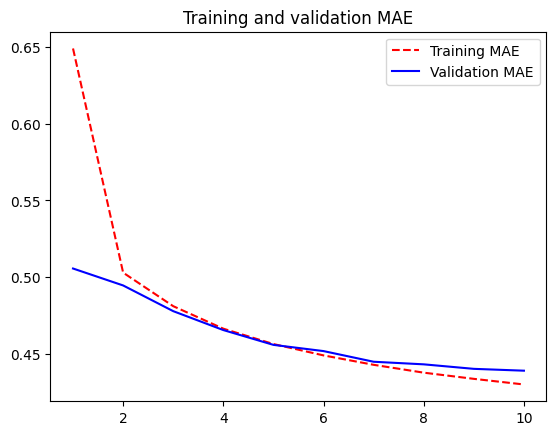

In [61]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [62]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "paphos_stacked_gru_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("paphos_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 0.5432 - mae: 0.5840 - val_loss: 0.3039 - val_mae: 0.4381
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.4053 - mae: 0.5041 - val_loss: 0.3012 - val_mae: 0.4348
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.3808 - mae: 0.4886 - val_loss: 0.3123 - val_mae: 0.4423
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.3688 - mae: 0.4788 - val_loss: 0.3182 - val_mae: 0.4441
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.3604 - mae: 0.4737 - val_loss: 0.3187 - val_mae: 0.4436
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.3566 - mae: 0.4688 - val_loss: 0.3191 - val_mae: 0.4436
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.3501 - mae: 0.4654 - val_loss: 0.3176 - val_mae: 0.4429
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.3465 - mae: 0.4630 - val_loss: 0.3259 - val_mae: 0.4479
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - l

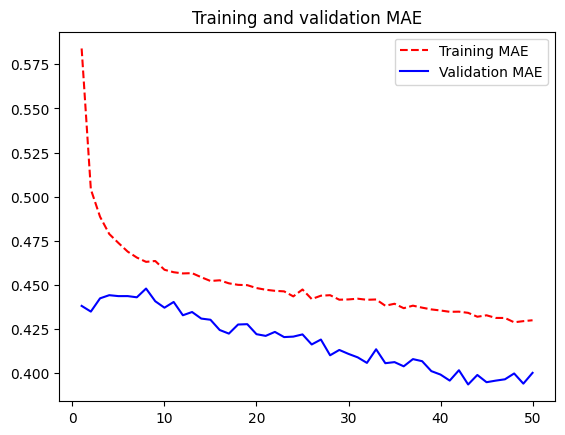

In [63]:

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()